# Preparation data and base dependenses

In [1]:
import torch
import numpy as np

train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [2]:
import PIL
print(PIL.__version__)

9.4.0


In [3]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [4]:
!unzip -q /content/gdrive/MyDrive/journey-springfield.zip

In [5]:
!ls train

simpsons_dataset


In [6]:
!nvidia-smi
import torch
torch.cuda.is_available()

Sun Dec  3 19:34:57 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   63C    P8    11W /  70W |      3MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

True

# Convertation data

In [26]:
import os
from tqdm.autonotebook import tqdm, trange

import torch
import torch.optim as optim
from torch.optim import lr_scheduler

import torchvision
from torchvision import datasets, models, transforms

import pickle
import numpy as np
from skimage import io

from tqdm import tqdm, tqdm_notebook
from PIL import Image
from pathlib import Path

from torchvision import transforms
from multiprocessing.pool import ThreadPool
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn

from matplotlib import colors, pyplot as plt
%matplotlib inline


import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)

In [27]:
DATA_MODES = ['train', 'val', 'test']

RESCALE_SIZE = 224

DEVICE = torch.device('cuda')

if not train_on_gpu:
    DEVICE = torch.device('cpu')

DEVICE

device(type='cuda')

Для улучшения качества также в transfrom.Compose() дообавим аугментацию(RANDOMHORIZONTALFLIP 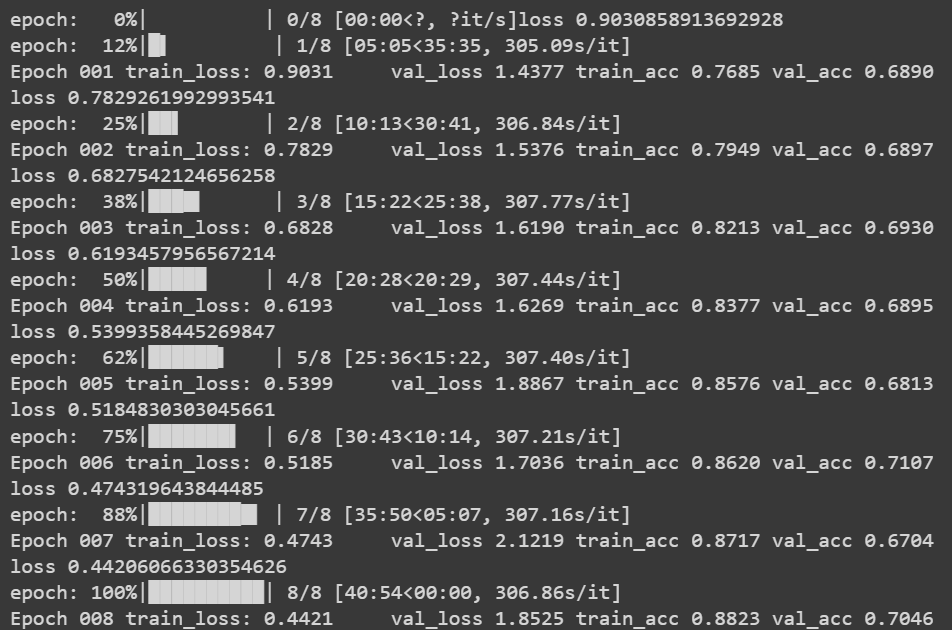)

In [28]:
class SimpsonsDataset(Dataset):
    def __init__(self, files, mode):
        super().__init__()
        self.files = sorted(files)
        self.mode = mode

        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError

        self.len_ = len(self.files)

        self.label_encoder = LabelEncoder()

        if self.mode != 'test':
            self.labels = [path.parent.name for path in self.files]
            self.label_encoder.fit(self.labels)

            with open('label_encoder.pkl', 'wb') as le_dump_file:
                  pickle.dump(self.label_encoder, le_dump_file)

    def __len__(self):
        return self.len_

    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image

    def __getitem__(self, index):
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
            transforms.RandomHorizontalFlip(p=0.4),
            transforms.RandomRotation(degrees=(30, 60))
        ])
        x = self.load_sample(self.files[index])
        x = self._prepare_sample(x)
        x = np.array(x / 255, dtype='float32')
        x = transform(x)
        if self.mode == 'test':
            return x
        else:
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y

    def _prepare_sample(self, image):
        image = image.resize((RESCALE_SIZE, RESCALE_SIZE))
        return np.array(image)

In [29]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow для тензоров"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

In [30]:
TRAIN_DIR = Path('./train/')
TEST_DIR = Path('./testset')

In [31]:
train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))
test_files = sorted(list(TEST_DIR.rglob('*.jpg')))

In [32]:
from sklearn.model_selection import train_test_split

train_val_labels = [path.parent.name for path in train_val_files]
train_files, val_files = train_test_split(train_val_files, test_size=0.25, \
                                          stratify=train_val_labels)

In [33]:
val_dataset = SimpsonsDataset(val_files, mode='val')

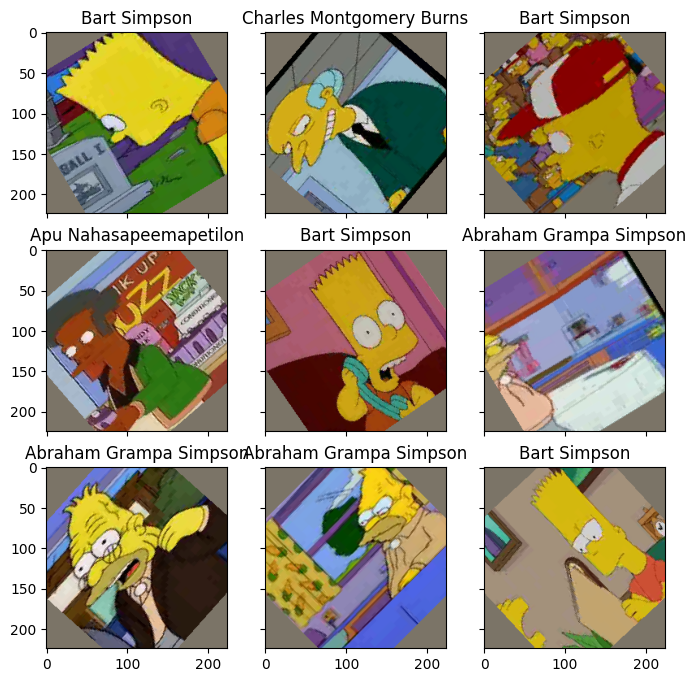

In [34]:
fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(8, 8), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)

ammount of labels in problem:

In [35]:
n_classes = len(np.unique(train_val_labels))
n_classes

42

# Different models experiments

## VGG16
Сперва попробуем эту сеть, так как на семинарах она давала точность выше, чем AlexNet и ResNet

In [22]:
model_extractor = models.vgg16(pretrained=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:04<00:00, 133MB/s]


Параметры Fully Connectted слоев:

In [23]:
model_extractor.classifier

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=4096, out_features=1000, bias=True)
)

In [27]:
model_extractor = model_extractor.to(DEVICE)

for param in model_extractor.parameters():
  param.reqiures_grad = False

num_features = model_extractor.classifier[6].in_features
model_extractor.classifier[6] = nn.Linear(in_features=num_features, out_features=n_classes)

learning_rate = 1e-4
opt = optim.Adam(model_extractor.classifier.parameters(), lr = learning_rate)
scheduler = optim.lr_scheduler.StepLR(optimizer=opt, step_size=10, gamma=0.1)

criterion = nn.CrossEntropyLoss()

Посмотрим, как теперь выглядит классификатор

In [25]:
model_extractor.classifier

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=4096, out_features=42, bias=True)
)

## Inception v3
Попробуем этот варинат, так как VGG16 не оправдал ожиданий(accuracy on validation dataset = 0.7864)

In [17]:
model_inceptionv3_01 = models.inception_v3(pretrained=True).to(DEVICE)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth
100%|██████████| 104M/104M [00:04<00:00, 24.3MB/s]


In [18]:
model_inceptionv3_01.AuxLogits

InceptionAux(
  (conv0): BasicConv2d(
    (conv): Conv2d(768, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(128, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv1): BasicConv2d(
    (conv): Conv2d(128, 768, kernel_size=(5, 5), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(768, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (fc): Linear(in_features=768, out_features=1000, bias=True)
)

In [19]:
model_inceptionv3_01.AuxLogits.fc

Linear(in_features=768, out_features=1000, bias=True)

То есть есть один линейный слой, который выводит значения, которые мы потом загоняем в softmax

In [20]:
model_inceptionv3_01.parameters()

<generator object Module.parameters at 0x7ec5860a94d0>

In [21]:
model_inceptionv3_01.AuxLogits.fc = nn.Linear(in_features=768, out_features=n_classes)

# for param in model_extractor.parameters():
#   param.reqiures_grad = False

learning_rate = 1e-4
opt = optim.Adam(model_inceptionv3_01.AuxLogits.fc.parameters(), lr = learning_rate)
scheduler = optim.lr_scheduler.StepLR(optimizer=opt, step_size=10, gamma=0.1)

criterion = nn.CrossEntropyLoss()

## VGG19

In [48]:
model_vgg19 = models.vgg19(pretrained=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Посмотрим, как выглядит classifier для этой сети

In [49]:
model_vgg19.classifier

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=4096, out_features=1000, bias=True)
)

Попробуем в этот раз оставить только один fully connected слой(в VGG16 я менял только последний)

In [50]:
for param in model_vgg19.parameters():
  param.requires_grad = False

input_features = model_vgg19.classifier[0].in_features
model_vgg19.classifier = nn.Linear(in_features=input_features, out_features=n_classes)

learning_rate = 3e-4
opt = optim.Adam(model_vgg19.classifier.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.StepLR(optimizer=opt, step_size=10, gamma=0.1)

criterion = nn.CrossEntropyLoss()

теперь количество слоев для классификации сократилось, что должно помочь не переобучаться на маленьком датасете

In [51]:
model_vgg19.classifier

Linear(in_features=25088, out_features=42, bias=True)

In [52]:
model_vgg19 = model_vgg19.to(DEVICE)

## Resnet

In [79]:
model_resnet18 = models.resnet18(pretrained=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 49.0MB/s]


Посмторим, как устроена сеть:

In [83]:
model_resnet18

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Изменим fc слой:

In [84]:
input_features = model_resnet18.fc.in_features
model_resnet18.fc = nn.Linear(in_features=input_features, out_features=n_classes)

opt = torch.optim.Adam(params=[
    {"params": model_resnet18.fc.parameters()},
    {"params": model_resnet18.layer1.parameters(), "lr": 1e-5,},
    {"params": model_resnet18.layer2.parameters(), "lr": 1e-5,},
    {"params": model_resnet18.layer3.parameters(), "lr": 1e-5,},
    {"params": model_resnet18.layer4.parameters(), "lr": 1e-5,}
], lr=1e-4, amsgrad=True)
scheduler = optim.lr_scheduler.StepLR(optimizer=opt, step_size=10, gamma=0.1)

criterion = nn.CrossEntropyLoss()

In [85]:
model_resnet18 = model_resnet18.to(DEVICE)

# Train process

In [86]:
def fit_epoch(model, train_loader, criterion, optimizer):
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0

    for inputs, labels in train_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        preds = torch.argmax(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)

    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data
    return train_loss, train_acc

In [87]:
def eval_epoch(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0

    for inputs, labels in val_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_size += inputs.size(0)
    val_loss = running_loss / processed_size
    val_acc = running_corrects.double() / processed_size
    return val_loss, val_acc

In [88]:
def train(train_files, val_files, model, epochs, batch_size, opt, criterion):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:

        for epoch in range(epochs):
            train_loss, train_acc = fit_epoch(model, train_loader, criterion, opt)
            print("loss", train_loss)

            val_loss, val_acc = eval_epoch(model, val_loader, criterion)
            history.append((train_loss, train_acc, val_loss, val_acc))

            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))

    return history

In [89]:
if val_dataset is None:
    val_dataset = SimpsonsDataset(val_files, mode='val')

train_dataset = SimpsonsDataset(train_files, mode='train')

In [91]:
history = train(train_dataset, val_dataset, model=model_vgg19.to(DEVICE), epochs=15, batch_size=64, criterion = criterion, opt = opt)

epoch:   0%|          | 0/15 [00:00<?, ?it/s]

loss 0.39101818855656123


epoch:   7%|▋         | 1/15 [05:12<1:12:48, 312.01s/it]


Epoch 001 train_loss: 0.3910     val_loss 1.8909 train_acc 0.8960 val_acc 0.7079
loss 0.381307529464589


epoch:  13%|█▎        | 2/15 [10:26<1:07:53, 313.32s/it]


Epoch 002 train_loss: 0.3813     val_loss 1.8704 train_acc 0.8952 val_acc 0.7121
loss 0.40295091798764304


epoch:  20%|██        | 3/15 [15:35<1:02:16, 311.36s/it]


Epoch 003 train_loss: 0.4030     val_loss 1.8629 train_acc 0.8927 val_acc 0.7094
loss 0.37683462972038906


epoch:  27%|██▋       | 4/15 [20:46<57:02, 311.11s/it]


Epoch 004 train_loss: 0.3768     val_loss 1.8819 train_acc 0.8960 val_acc 0.7100
loss 0.37966147290497754


epoch:  33%|███▎      | 5/15 [25:56<51:50, 311.06s/it]


Epoch 005 train_loss: 0.3797     val_loss 1.8655 train_acc 0.8982 val_acc 0.7014
loss 0.3755582973975134


epoch:  40%|████      | 6/15 [31:10<46:46, 311.87s/it]


Epoch 006 train_loss: 0.3756     val_loss 1.9053 train_acc 0.8982 val_acc 0.7025
loss 0.37388514235655596


epoch:  47%|████▋     | 7/15 [36:24<41:40, 312.59s/it]


Epoch 007 train_loss: 0.3739     val_loss 1.8527 train_acc 0.8990 val_acc 0.7125
loss 0.38745898965593584


epoch:  53%|█████▎    | 8/15 [41:37<36:28, 312.64s/it]


Epoch 008 train_loss: 0.3875     val_loss 1.8926 train_acc 0.8938 val_acc 0.7090
loss 0.3643399146197138


epoch:  60%|██████    | 9/15 [46:50<31:16, 312.79s/it]


Epoch 009 train_loss: 0.3643     val_loss 1.8962 train_acc 0.9007 val_acc 0.7048
loss 0.38524887390794005


epoch:  67%|██████▋   | 10/15 [52:01<26:01, 312.34s/it]


Epoch 010 train_loss: 0.3852     val_loss 1.8271 train_acc 0.8948 val_acc 0.7102
loss 0.37899002754405026


epoch:  73%|███████▎  | 11/15 [57:09<20:44, 311.04s/it]


Epoch 011 train_loss: 0.3790     val_loss 1.8466 train_acc 0.8958 val_acc 0.7117
loss 0.3796039916381797


epoch:  80%|████████  | 12/15 [1:02:19<15:31, 310.54s/it]


Epoch 012 train_loss: 0.3796     val_loss 1.8679 train_acc 0.8944 val_acc 0.7090
loss 0.37154914610051326


epoch:  87%|████████▋ | 13/15 [1:07:27<10:19, 309.89s/it]


Epoch 013 train_loss: 0.3715     val_loss 1.8930 train_acc 0.8975 val_acc 0.7046
loss 0.3768944105674328


epoch:  93%|█████████▎| 14/15 [1:12:34<05:09, 309.05s/it]


Epoch 014 train_loss: 0.3769     val_loss 1.8305 train_acc 0.8943 val_acc 0.7125
loss 0.3767530546413348


epoch: 100%|██████████| 15/15 [1:17:42<00:00, 310.81s/it]


Epoch 015 train_loss: 0.3768     val_loss 1.8496 train_acc 0.8920 val_acc 0.7090


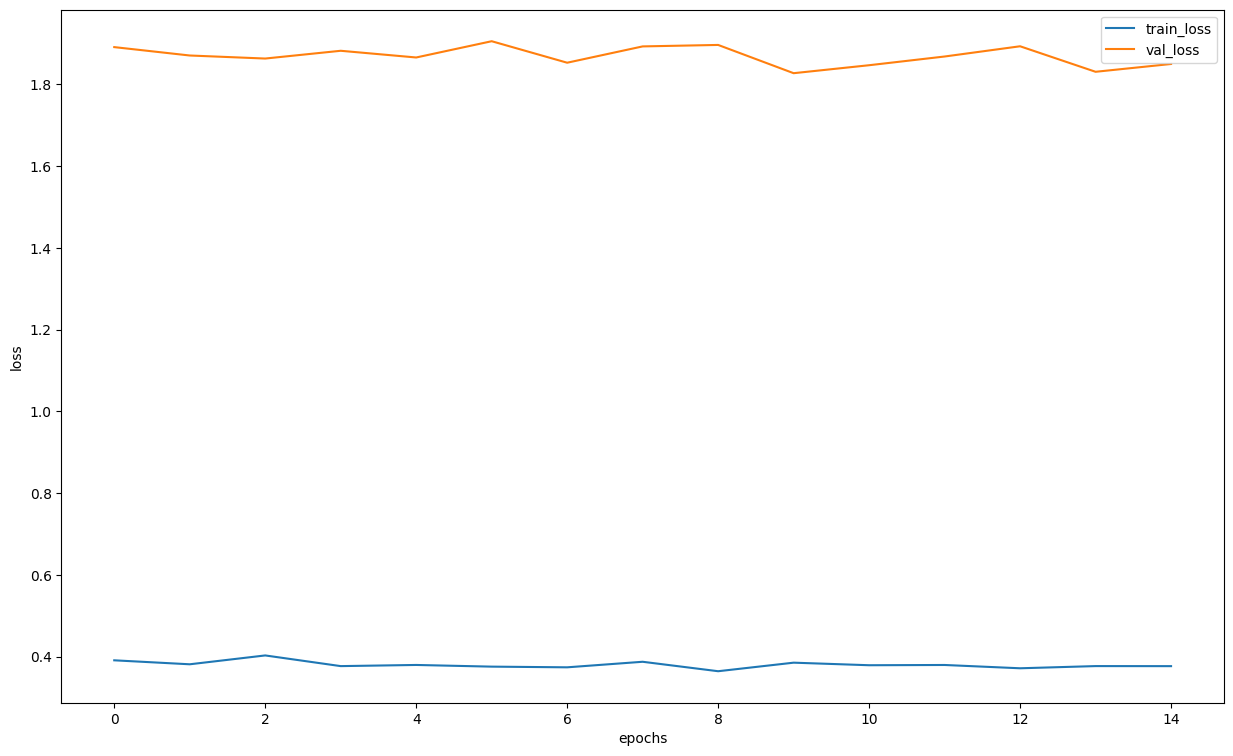

In [92]:
loss, acc, val_loss, val_acc = zip(*history)

plt.figure(figsize=(15, 9))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

Сохраним веса модели

In [94]:
torch.save(model_vgg19.state_dict(), "trained_resnet18_01.pt")

# Calculating F1 metric

In [95]:
def predict_one_sample(model, inputs, device=DEVICE):
    with torch.no_grad():
        inputs = inputs.to(device)
        model.eval()
        logit = model(inputs)
        probs = torch.nn.functional.softmax(logit.cpu(), dim=-1).numpy()
    return probs

In [96]:
random_characters = int(np.random.uniform(0,1000))
ex_img, true_label = val_dataset[random_characters]
probs_im = predict_one_sample(model_vgg19.to(DEVICE), ex_img.unsqueeze(0))

In [97]:
def predict(model, test_loader):
    with torch.no_grad():
        logits = []

        for inputs in test_loader:
            inputs = inputs.to(DEVICE)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)

    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

In [98]:
idxs = list(map(int, np.random.uniform(0,1000, 20)))
imgs = [val_dataset[id][0].unsqueeze(0) for id in idxs]

probs_ims = predict(model_vgg19.to(DEVICE), imgs)

In [69]:
label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))

In [70]:
y_pred = np.argmax(probs_ims,-1)

actual_labels = [val_dataset[id][1] for id in idxs]

preds_class = [label_encoder.classes_[i] for i in y_pred]

In [71]:
from sklearn.metrics import f1_score
f1 = f1_score(actual_labels, y_pred, average='micro')

print("F1-оценка:", f1)

F1-оценка: 0.8000000000000002


# Results for every experiminet

## VGG19 с одним слоем классификации:
epoch:   0%|          | 0/8 [00:00<?, ?it/s]loss 0.9030858913692928\
epoch:  12%|█▎        | 1/8 [05:05<35:35, 305.09s/it]\
Epoch 001 train_loss: 0.9031     val_loss 1.4377 train_acc 0.7685 val_acc 0.6890
loss 0.7829261992993541\
epoch:  25%|██▌       | 2/8 [10:13<30:41, 306.84s/it]\
Epoch 002 train_loss: 0.7829     val_loss 1.5376 train_acc 0.7949 val_acc 0.6897
loss 0.6827542124656258\
epoch:  38%|███▊      | 3/8 [15:22<25:38, 307.77s/it]
Epoch 003 train_loss: 0.6828     val_loss 1.6190 train_acc 0.8213 val_acc 0.6930
loss 0.6193457956567214\
epoch:  50%|█████     | 4/8 [20:28<20:29, 307.44s/it]\
Epoch 004 train_loss: 0.6193     val_loss 1.6269 train_acc 0.8377 val_acc 0.6895
loss 0.5399358445269847\
epoch:  62%|██████▎   | 5/8 [25:36<15:22, 307.40s/it]\
Epoch 005 train_loss: 0.5399     val_loss 1.8867 train_acc 0.8576 val_acc 0.6813
loss 0.5184830303045661\
epoch:  75%|███████▌  | 6/8 [30:43<10:14, 307.21s/it]\
Epoch 006 train_loss: 0.5185     val_loss 1.7036 train_acc 0.8620 val_acc 0.7107
loss 0.474319643844485\
epoch:  88%|████████▊ | 7/8 [35:50<05:07, 307.16s/it]\
Epoch 007 train_loss: 0.4743     val_loss 2.1219 train_acc 0.8717 val_acc 0.6704
loss 0.44206066330354626\
epoch: 100%|██████████| 8/8 [40:54<00:00, 306.86s/it]\
Epoch 008 train_loss: 0.4421     val_loss 1.8525 train_acc 0.8823 val_acc 0.7046


F1 metric: 0.8000000000000002

## Resnet18
epoch:   0%|          | 0/15 [00:00<?, ?it/s]loss 0.39101818855656123\
epoch:   7%|▋         | 1/15 [05:12<1:12:48, 312.01s/it]\
Epoch 001 train_loss: 0.3910     val_loss 1.8909 train_acc 0.8960 val_acc 0.7079
loss 0.381307529464589\
epoch:  13%|█▎        | 2/15 [10:26<1:07:53, 313.32s/it]\
Epoch 002 train_loss: 0.3813     val_loss 1.8704 train_acc 0.8952 val_acc 0.7121
loss 0.40295091798764304\
epoch:  20%|██        | 3/15 [15:35<1:02:16, 311.36s/it]\
Epoch 003 train_loss: 0.4030     val_loss 1.8629 train_acc 0.8927 val_acc 0.7094
loss 0.37683462972038906\
epoch:  27%|██▋       | 4/15 [20:46<57:02, 311.11s/it]\
Epoch 004 train_loss: 0.3768     val_loss 1.8819 train_acc 0.8960 val_acc 0.7100
loss 0.37966147290497754\
epoch:  33%|███▎      | 5/15 [25:56<51:50, 311.06s/it]\
Epoch 005 train_loss: 0.3797     val_loss 1.8655 train_acc 0.8982 val_acc 0.7014
loss 0.3755582973975134\
epoch:  40%|████      | 6/15 [31:10<46:46, 311.87s/it]\
Epoch 006 train_loss: 0.3756     val_loss 1.9053 train_acc 0.8982 val_acc 0.7025
loss 0.37388514235655596\
epoch:  47%|████▋     | 7/15 [36:24<41:40, 312.59s/it]\
Epoch 007 train_loss: 0.3739     val_loss 1.8527 train_acc 0.8990 val_acc 0.7125
loss 0.38745898965593584\
epoch:  53%|█████▎    | 8/15 [41:37<36:28, 312.64s/it]\
Epoch 008 train_loss: 0.3875     val_loss 1.8926 train_acc 0.8938 val_acc 0.7090
loss 0.3643399146197138\
epoch:  60%|██████    | 9/15 [46:50<31:16, 312.79s/it]\
Epoch 009 train_loss: 0.3643     val_loss 1.8962 train_acc 0.9007 val_acc 0.7048
loss 0.38524887390794005\
epoch:  67%|██████▋   | 10/15 [52:01<26:01, 312.34s/it]\
Epoch 010 train_loss: 0.3852     val_loss 1.8271 train_acc 0.8948 val_acc 0.7102
loss 0.37899002754405026\
epoch:  73%|███████▎  | 11/15 [57:09<20:44, 311.04s/it]
Epoch 011 train_loss: 0.3790     val_loss 1.8466 train_acc 0.8958 val_acc 0.7117
loss 0.3796039916381797\
epoch:  80%|████████  | 12/15 [1:02:19<15:31, 310.54s/it]
Epoch 012 train_loss: 0.3796     val_loss 1.8679 train_acc 0.8944 val_acc 0.7090
loss 0.37154914610051326\
epoch:  87%|████████▋ | 13/15 [1:07:27<10:19, 309.89s/it]
Epoch 013 train_loss: 0.3715     val_loss 1.8930 train_acc 0.8975 val_acc 0.7046
loss 0.3768944105674328\
epoch:  93%|█████████▎| 14/15 [1:12:34<05:09, 309.05s/it]\
Epoch 014 train_loss: 0.3769     val_loss 1.8305 train_acc 0.8943 val_acc 0.7125
loss 0.3767530546413348\
epoch: 100%|██████████| 15/15 [1:17:42<00:00, 310.81s/it]\
Epoch 015 train_loss: 0.3768     val_loss 1.8496 train_acc 0.8920 val_acc 0.7090

# Submit on Kaggle

In [74]:
test_dataset = SimpsonsDataset(test_files, mode="test")
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=64)
probs = predict(model_vgg19, test_loader)


preds = label_encoder.inverse_transform(np.argmax(probs, axis=1))
test_filenames = [path.name for path in test_dataset.files]

In [75]:
! ls

characters_illustration.png  label_encoder.pkl	sample_submission.csv  train
gdrive			     sample_data	testset		       trained_vgg19_01.pt


In [76]:
import pandas as pd
my_submit = pd.read_csv("/content/sample_submission.csv")
# my_submit = pd.DataFrame({'Image_id': test_filenames, 'Expected': preds})
my_submit.head()

,Id,Expected
0,img0.jpg,bart_simpson
1,img1.jpg,bart_simpson
2,img2.jpg,bart_simpson
3,img3.jpg,bart_simpson
4,img4.jpg,bart_simpson


In [78]:
my_submit.to_csv('vgg19_01.csv', index=False)